In [1]:
import os
import csv
import torch
import random
import timeit
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn import preprocessing
from audtorch.metrics.functional import concordance_cc
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# data preparation

with open('/Users/liyuanchao/Documents/Corpora/IMPRESSION/feats_labels/feats_stimuli/sti.csv') as sti:
    file_content = csv.reader(sti, delimiter=',')
    headers = next(file_content, None)
    feats_sti = list(file_content)

feats_par = []
listener = []
ind = []
comp = []
warm = []

path_feats = '/Users/liyuanchao/Documents/Corpora/IMPRESSION/feats_labels/feats_participant/'
path_labels = '/Users/liyuanchao/Documents/Corpora/IMPRESSION/feats_labels/labels/'

os.chdir(path_feats)
for file in range(40):
    with open(str(file) + '.csv') as par:
        file_content = csv.reader(par, delimiter=',')
        headers = next(file_content, None)
        for row in list(file_content):
            feats_par.append(row[:-1])
            ind.append(row[-1])
            listener.append(file)

os.chdir(path_labels)
for file in range(40):
    with open(str(file) + '.csv') as label:
        file_content = csv.reader(label, delimiter=',')
        headers = next(file_content, None)
        for row in list(file_content):
            comp.append(row[0])
            warm.append(row[1])

In [3]:
feats_par = np.array(feats_par, dtype=float)
feats_sti = np.array(feats_sti, dtype=float)
listener = np.array(listener, dtype=float)
comp = np.array(comp, dtype=float)
warm = np.array(warm, dtype=float)
ind = np.array(ind, dtype=int)

In [4]:
# shuffle data
leng = len(feats_par)
indices = np.arange(leng)
random.shuffle(indices)
feats_par[np.arange(leng)] = feats_par[indices]
listener[np.arange(leng)] = listener[indices]
comp[np.arange(leng)] = comp[indices]
warm[np.arange(leng)] = warm[indices]
ind[np.arange(leng)] = ind[indices]

# separate training and validation data
feats_train = feats_par[:int(0.8*leng)]
feats_valid = feats_par[int(0.8*leng):int(0.9*leng)]
feats_test = feats_par[int(0.9*leng):]
listener_train = listener[:int(0.8*leng)]
listener_valid = listener[int(0.8*leng):int(0.9*leng)]
listener_test = listener[int(0.9*leng):]
comp_train = comp[:int(0.8*leng)]
comp_valid = comp[int(0.8*leng):int(0.9*leng)]
comp_test = comp[int(0.9*leng):]
warm_train = warm[:int(0.8*leng)]
warm_valid = warm[int(0.8*leng):int(0.9*leng)]
warm_test = warm[int(0.9*leng):]
ind_train = ind[:int(0.8*leng)]
ind_valid = ind[int(0.8*leng):int(0.9*leng)]
ind_test = ind[int(0.9*leng):]

# normalization
feats_train -= np.mean(feats_train, axis = 0)
feats_train /= np.std(feats_train, axis = 0)
feats_valid -= np.mean(feats_valid, axis = 0)
feats_valid /= np.std(feats_valid, axis = 0)
feats_test -= np.mean(feats_test, axis = 0)
feats_test /= np.std(feats_test, axis = 0)
feats_sti -= np.mean(feats_sti, axis = 0)
feats_sti /= np.std(feats_sti, axis = 0)

In [5]:
feats_sti = torch.from_numpy(feats_sti)
feats_train = torch.from_numpy(feats_train)
feats_valid = torch.from_numpy(feats_valid)
feats_test = torch.from_numpy(feats_test)
listener_train = torch.from_numpy(listener_train)
listener_valid = torch.from_numpy(listener_valid)
listener_test = torch.from_numpy(listener_test)
ind_train = torch.from_numpy(ind_train)
ind_valid = torch.from_numpy(ind_valid)
ind_test = torch.from_numpy(ind_test)
comp_train = torch.from_numpy(comp_train)
comp_valid = torch.from_numpy(comp_valid)
comp_test = torch.from_numpy(comp_test)
warm_train = torch.from_numpy(warm_train)
warm_valid = torch.from_numpy(warm_valid)
warm_test = torch.from_numpy(warm_test)

print(feats_train.size(), feats_valid.size(), feats_test.size(), feats_sti.size())
print(listener_train.size(), listener_valid.size(), listener_test.size())
print(ind_train.size(), ind_valid.size(), ind_test.size())
print(comp_train.size(), comp_valid.size(), comp_test.size(), warm_train.size(), warm_valid.size(), warm_test.size())

trainset = TensorDataset(feats_train, listener_train, ind_train, comp_train, warm_train)
validset = TensorDataset(feats_valid, listener_valid, ind_valid, comp_valid, warm_valid)
testset = TensorDataset(feats_test, listener_test, ind_test, comp_test, warm_test)
traindata = DataLoader(dataset=trainset, batch_size=64, shuffle=False)
validdata = DataLoader(dataset=validset, batch_size=64, shuffle=False)
testdata = DataLoader(dataset=testset, batch_size=64, shuffle=False)

print('Data preparation completed!')

torch.Size([1437536, 68]) torch.Size([179692, 68]) torch.Size([179692, 68]) torch.Size([44923, 412])
torch.Size([1437536]) torch.Size([179692]) torch.Size([179692])
torch.Size([1437536]) torch.Size([179692]) torch.Size([179692])
torch.Size([1437536]) torch.Size([179692]) torch.Size([179692]) torch.Size([1437536]) torch.Size([179692]) torch.Size([179692])
Data preparation completed!


In [6]:
# model baseline
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(feats_par[0]),
                            hidden_size=64,
                            num_layers=2,
                            dropout=0.5,
                            batch_first=True,
                            bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=len(feats_sti[0]),
                            hidden_size=64,
                            num_layers=2,
                            dropout=0.5,
                            batch_first=True,
                            bidirectional=True)
        self.attn = nn.MultiheadAttention(128, 16, batch_first=True)
        self.dense = nn.Linear(128, 16)
        self.acti = nn.ReLU()
        self.out = nn.Linear(16, 1)
        
    def forward(self, input_par, input_sti):
        # lstm
        self.lstm1.flatten_parameters()
        self.lstm2.flatten_parameters()
        x_par, _ = self.lstm1(input_par)
        x_sti, _ = self.lstm2(input_sti)
        # attention
        x_par, _ = self.attn(x_par, x_par, x_par)
        x_sti, _ = self.attn(x_sti, x_sti, x_sti)
        x_par_sti, _ = self.attn(x_par, x_sti, x_sti)
        x_sti_par, _ = self.attn(x_sti, x_par, x_par)

        # distillation loss
        loss_dis1 = func(x_par, x_sti)
        loss_dis2 = func(x_sti, x_par)
        # similarity loss
        loss_sim1 = kl_func(nn.functional.log_softmax(x_par_sti, 0), nn.functional.softmax(x_par, 0))
        loss_sim2 = kl_func(nn.functional.log_softmax(x_sti_par, 0), nn.functional.softmax(x_sti, 0))

        # concatenation
        x_co = torch.cat((x_par, x_sti, x_par_sti, x_sti_par), 1)
        x_co = x_co.mean(dim=1)  # pooling
        x_co = self.dense(x_co)
        x_co = self.acti(x_co)
        comp = self.out(x_co)
        warm = self.out(x_co)
        return comp, warm, loss_dis1, loss_dis2, loss_sim1, loss_sim2

In [8]:
#baseline

torch.manual_seed(1)
model = NeuralNet()
model = model.to(torch.float64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
func = nn.MSELoss()
kl_func = nn.KLDivLoss(reduction='batchmean')

sim_loss_train = []
dis_loss_train = []
sim_loss_valid = []
dis_loss_valid = []

# training
for epoch in range(40):
    start = timeit.default_timer()
    print("-----epoch: ", epoch, "-----")
    comp_loss_list_train = []
    comp_loss_list_valid = []
    warm_loss_list_train = []
    warm_loss_list_valid = []
    sim_loss_list_train = []
    sim_loss_list_valid = []
    dis_loss_list_train = []
    dis_loss_list_valid = []
    comp_preds_train = []
    comp_preds_valid = []
    comp_preds_test = []
    warm_preds_train = []
    warm_preds_valid = []
    warm_preds_test = []     
    
    print('--training begins--')
    model.train()
    for input_par, input_lis, inds, labels_comp, labels_warm in traindata:
        input_sti = torch.tensor([])
        for inde in inds:
            input_sti = torch.cat((input_sti, feats_sti[inde]), 0)
        input_par = input_par.reshape(input_par.shape[0], 1, input_par.shape[1])
        input_sti = input_sti.reshape(input_par.shape[0], 1, -1)
        # loss
        preds_comp, preds_warm, loss_dis1, loss_dis2, loss_sim1, loss_sim2 = model(input_par, input_sti)
        train_loss_comp = func(preds_comp.squeeze(), labels_comp)
        train_loss_warm = func(preds_warm.squeeze(), labels_warm)
        loss_sim = loss_sim1 + loss_sim2
        loss_dis = loss_dis1 + loss_dis2
        train_cross_loss = loss_dis + loss_sim
        comp_loss_list_train.append(train_loss_comp.item())
        warm_loss_list_train.append(train_loss_warm.item())
        sim_loss_list_train.append(loss_sim.item())
        dis_loss_list_train.append(loss_dis.item())
        for i in preds_comp:
            comp_preds_train.append(i.item())
        for i in preds_warm:
            warm_preds_train.append(i.item())
        # backprop
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        train_loss = train_loss_comp + train_loss_warm + train_cross_loss
        train_loss.backward()
        optimizer.step()

# validation
    print('--validation begins--')
    model.eval()
    input_par = feats_valid
    for input_par, input_lis, inds, labels_comp, labels_warm in validdata:
        input_sti = torch.tensor([])
        for inde in inds:
            input_sti = torch.cat((input_sti, feats_sti[inde]), 0)
        input_par = input_par.reshape(input_par.shape[0], 1, input_par.shape[1])
        input_sti = input_sti.reshape(input_par.shape[0], 1, -1)
        # loss
        preds_comp, preds_warm, loss_dis1, loss_dis2, loss_sim1, loss_sim2 = model(input_par, input_sti)
        valid_loss_comp = func(preds_comp.squeeze(), labels_comp)
        valid_loss_warm = func(preds_warm.squeeze(), labels_warm)
        loss_sim = loss_sim1 + loss_sim2
        loss_dis = loss_dis1 + loss_dis2
        comp_loss_list_valid.append(valid_loss_comp.item())
        warm_loss_list_valid.append(valid_loss_warm.item())
        sim_loss_list_valid.append(loss_sim.item())
        dis_loss_list_valid.append(loss_dis.item())
        for i in preds_comp:
            comp_preds_valid.append(i.item())
        for i in preds_warm:
            warm_preds_valid.append(i.item())
    
# test
    print('--testing begins--')
    input_par = feats_test
    for input_par, input_lis, inds, labels_comp, labels_warm in testdata:
        input_sti = torch.tensor([])
        for inde in inds:
            input_sti = torch.cat((input_sti, feats_sti[inde]), 0)
        input_par = input_par.reshape(input_par.shape[0], 1, input_par.shape[1])
        input_sti = input_sti.reshape(input_par.shape[0], 1, -1)
        # loss
        preds_comp, preds_warm, _, _, _, _ = model(input_par, input_sti)
        for i in preds_comp:
            comp_preds_test.append(i.item())
        for i in preds_warm:
            warm_preds_test.append(i.item())
            
    # compute performance for each epoch
    comp_preds_train = torch.tensor(comp_preds_train)
    warm_preds_train = torch.tensor(warm_preds_train)
    comp_preds_valid = torch.tensor(comp_preds_valid)
    warm_preds_valid = torch.tensor(warm_preds_valid)
    comp_preds_test = torch.tensor(comp_preds_test)
    warm_preds_test = torch.tensor(warm_preds_test)

    train_ccc_comp = concordance_cc(comp_preds_train, comp_train)
    train_ccc_warm = concordance_cc(warm_preds_train, warm_train)
    valid_ccc_comp = concordance_cc(comp_preds_valid, comp_valid)
    valid_ccc_warm = concordance_cc(warm_preds_valid, warm_valid)
    test_ccc_comp = concordance_cc(comp_preds_test, comp_test)
    test_ccc_warm = concordance_cc(warm_preds_test, warm_test)

    train_loss_comp = sum(comp_loss_list_train) / len(comp_loss_list_train)
    train_loss_warm = sum(warm_loss_list_train) / len(warm_loss_list_train)
    valid_loss_comp = sum(comp_loss_list_valid) / len(comp_loss_list_valid)
    valid_loss_warm = sum(warm_loss_list_valid) / len(warm_loss_list_valid)
    train_loss_sim = sum(sim_loss_list_train) / len(sim_loss_list_train)
    train_loss_dis = sum(dis_loss_list_train) / len(dis_loss_list_train)
    valid_loss_sim = sum(sim_loss_list_valid) / len(sim_loss_list_valid)
    valid_loss_dis = sum(dis_loss_list_valid) / len(dis_loss_list_valid)
    
    sim_loss_train.append(train_loss_sim)
    dis_loss_train.append(train_loss_dis)
    sim_loss_valid.append(valid_loss_sim)
    dis_loss_valid.append(valid_loss_dis)
        
    print('train_loss_comp: %.4f' % train_loss_comp, '|train_ccc_comp: %.4f' % train_ccc_comp, '\n'
          'train_loss_warm: %.4f' % train_loss_warm, '|train_ccc_warm: %.4f' % train_ccc_warm, '\n'
          'valid_loss_comp: %.4f' % valid_loss_comp, '|valid_ccc_comp: %.4f' % valid_ccc_comp, '\n'
          'valid_loss_warm: %.4f' % valid_loss_warm, '|valid_ccc_warm: %.4f' % valid_ccc_warm, '\n'
          'test_ccc_comp: %.4f' % test_ccc_comp, '|test_ccc_warm: %.4f' % test_ccc_warm, '\n'
          'train_loss_sim: %.4f' % train_loss_sim, '|valid_loss_sim: %.4f' % valid_loss_sim, '\n'
          'train_loss_dis: %.4f' % train_loss_dis, '|valid_loss_dis: %.4f' % valid_loss_dis)

    stop = timeit.default_timer()
    print('Time: ', stop - start)
    scheduler.step()

-----epoch:  0 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 9.0807 |train_ccc_comp: 0.4217 
train_loss_warm: 7.8227 |train_ccc_warm: 0.4192 
valid_loss_comp: 7.1517 |valid_ccc_comp: 0.5818 
valid_loss_warm: 6.5742 |valid_ccc_warm: 0.5561 
test_ccc_comp: 0.5826 |test_ccc_warm: 0.5547 
train_loss_sim: 0.0794 |valid_loss_sim: 0.0885 
train_loss_dis: 0.0476 |valid_loss_dis: 0.0524
Time:  766.636249375
-----epoch:  1 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 7.2408 |train_ccc_comp: 0.5806 
train_loss_warm: 6.5337 |train_ccc_warm: 0.5651 
valid_loss_comp: 6.2197 |valid_ccc_comp: 0.6535 
valid_loss_warm: 5.7348 |valid_ccc_warm: 0.6340 
test_ccc_comp: 0.6540 |test_ccc_warm: 0.6316 
train_loss_sim: 0.0805 |valid_loss_sim: 0.0716 
train_loss_dis: 0.0541 |valid_loss_dis: 0.0513
Time:  806.181667667
-----epoch:  2 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 6.6475 |train_ccc_com

--validation begins--
--testing begins--
train_loss_comp: 5.2824 |train_ccc_comp: 0.7226 
train_loss_warm: 5.0247 |train_ccc_warm: 0.7011 
valid_loss_comp: 4.9632 |valid_ccc_comp: 0.7482 
valid_loss_warm: 4.6902 |valid_ccc_warm: 0.7301 
test_ccc_comp: 0.7475 |test_ccc_warm: 0.7293 
train_loss_sim: 0.0265 |valid_loss_sim: 0.0260 
train_loss_dis: 0.0301 |valid_loss_dis: 0.0298
Time:  806.8698048330007
-----epoch:  20 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 5.2010 |train_ccc_comp: 0.7277 
train_loss_warm: 4.9606 |train_ccc_warm: 0.7059 
valid_loss_comp: 4.9058 |valid_ccc_comp: 0.7479 
valid_loss_warm: 4.6244 |valid_ccc_warm: 0.7313 
test_ccc_comp: 0.7472 |test_ccc_warm: 0.7308 
train_loss_sim: 0.0254 |valid_loss_sim: 0.0244 
train_loss_dis: 0.0292 |valid_loss_dis: 0.0282
Time:  826.7982651659986
-----epoch:  21 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 5.1818 |train_ccc_comp: 0.7290 
train_loss_warm: 4.9

--validation begins--
--testing begins--
train_loss_comp: 5.0483 |train_ccc_comp: 0.7377 
train_loss_warm: 4.8455 |train_ccc_warm: 0.7152 
valid_loss_comp: 4.7309 |valid_ccc_comp: 0.7600 
valid_loss_warm: 4.6027 |valid_ccc_warm: 0.7368 
test_ccc_comp: 0.7593 |test_ccc_warm: 0.7364 
train_loss_sim: 0.0174 |valid_loss_sim: 0.0173 
train_loss_dis: 0.0205 |valid_loss_dis: 0.0202
Time:  736.3272573329996
-----epoch:  39 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 5.0489 |train_ccc_comp: 0.7376 
train_loss_warm: 4.8407 |train_ccc_warm: 0.7155 
valid_loss_comp: 4.7049 |valid_ccc_comp: 0.7615 
valid_loss_warm: 4.6314 |valid_ccc_warm: 0.7354 
test_ccc_comp: 0.7610 |test_ccc_warm: 0.7348 
train_loss_sim: 0.0173 |valid_loss_sim: 0.0172 
train_loss_dis: 0.0202 |valid_loss_dis: 0.0200
Time:  736.7511632909955


In [9]:
# model listener adaptation
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(feats_par[0]),
                            hidden_size=64,
                            num_layers=2,
                            dropout=0.5,
                            batch_first=True,
                            bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=len(feats_sti[0]),
                            hidden_size=64,
                            num_layers=2,
                            dropout=0.5,
                            batch_first=True,
                            bidirectional=True)
        self.lisadp = nn.Linear(40, 128)
        self.attn = nn.MultiheadAttention(128, 16, batch_first=True)
        self.dense = nn.Linear(128, 16)
        self.acti = nn.ReLU()
        self.out = nn.Linear(16, 1)
        
    def forward(self, input_par, input_sti, input_lis):
        # lstm
        self.lstm1.flatten_parameters()
        self.lstm2.flatten_parameters()
        x_par, _ = self.lstm1(input_par)
        x_sti, _ = self.lstm2(input_sti)
        # listener adaptive
        x_lis = self.lisadp(input_lis.to(torch.double))
        x_par = torch.cat((x_par, x_lis), 1)
        x_par = x_par.mean(dim=1).view(x_par.size()[0], 1, -1) # after concatenation, the size becomes (*, 2, *) from (*, 1, *), so using mean to reduce the dimension and view to reshape
        # attention
        x_par, _ = self.attn(x_par, x_par, x_par)
        x_sti, _ = self.attn(x_sti, x_sti, x_sti)
        x_par_sti, _ = self.attn(x_par, x_sti, x_sti)
        x_sti_par, _ = self.attn(x_sti, x_par, x_par)
        
        # distillation loss
        loss_dis1 = func(x_par, x_sti)
        loss_dis2 = func(x_sti, x_par)
        # similarity loss
        loss_sim1 = kl_func(nn.functional.log_softmax(x_par_sti, 0), nn.functional.softmax(x_par, 0))
        loss_sim2 = kl_func(nn.functional.log_softmax(x_sti_par, 0), nn.functional.softmax(x_sti, 0))

        # concatenation
        x_co = torch.cat((x_par, x_sti, x_par_sti, x_sti_par), 1)
        x_co = x_co.mean(dim=1)  # pooling
        x_co = self.dense(x_co)
        x_co = self.acti(x_co)
        comp = self.out(x_co)
        warm = self.out(x_co)
        return comp, warm, loss_dis1, loss_dis2, loss_sim1, loss_sim2

In [10]:
#listener adaptation

torch.manual_seed(1)
model = NeuralNet()
model = model.to(torch.float64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
func = nn.MSELoss()
kl_func = nn.KLDivLoss(reduction='batchmean')

sim_loss_train = []
dis_loss_train = []
sim_loss_valid = []
dis_loss_valid = []

# training
for epoch in range(40):
    start = timeit.default_timer()
    print("-----epoch: ", epoch, "-----")
    comp_loss_list_train = []
    comp_loss_list_valid = []
    warm_loss_list_train = []
    warm_loss_list_valid = []
    sim_loss_list_train = []
    sim_loss_list_valid = []
    dis_loss_list_train = []
    dis_loss_list_valid = []
    comp_preds_train = []
    comp_preds_valid = []
    comp_preds_test = []
    warm_preds_train = []
    warm_preds_valid = []
    warm_preds_test = []   
    
    print('--training begins--')
    model.train()
    for input_par, input_lis, inds, labels_comp, labels_warm in traindata:
        input_sti = torch.tensor([])
        for inde in inds:
            input_sti = torch.cat((input_sti, feats_sti[inde]), 0)
        input_par = input_par.reshape(input_par.shape[0], 1, input_par.shape[1])
        input_sti = input_sti.reshape(input_par.shape[0], 1, -1)
        input_lis = F.one_hot(input_lis.to(torch.int64), num_classes=40).reshape(input_lis.shape[0], 1, -1)
        # loss
        preds_comp, preds_warm, loss_dis1, loss_dis2, loss_sim1, loss_sim2 = model(input_par, input_sti, input_lis)
        train_loss_comp = func(preds_comp.squeeze(), labels_comp)
        train_loss_warm = func(preds_warm.squeeze(), labels_warm)
        loss_sim = loss_sim1 + loss_sim2
        loss_dis = loss_dis1 + loss_dis2
        train_cross_loss = loss_dis + loss_sim
        comp_loss_list_train.append(train_loss_comp.item())
        warm_loss_list_train.append(train_loss_warm.item())
        sim_loss_list_train.append(loss_sim.item())
        dis_loss_list_train.append(loss_dis.item())
        for i in preds_comp:
            comp_preds_train.append(i.item())
        for i in preds_warm:
            warm_preds_train.append(i.item())
        # backprop
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        train_loss = train_loss_comp + train_loss_warm + train_cross_loss
        train_loss.backward()
        optimizer.step()

# validation
    print('--validation begins--')
    model.eval()
    input_par = feats_valid
    for input_par, input_lis, inds, labels_comp, labels_warm in validdata:
        input_sti = torch.tensor([])
        for inde in inds:
            input_sti = torch.cat((input_sti, feats_sti[inde]), 0)
        input_par = input_par.reshape(input_par.shape[0], 1, input_par.shape[1])
        input_sti = input_sti.reshape(input_par.shape[0], 1, -1)
        input_lis = F.one_hot(input_lis.to(torch.int64), num_classes=40).reshape(input_lis.shape[0], 1, -1)
        # loss
        preds_comp, preds_warm, loss_dis1, loss_dis2, loss_sim1, loss_sim2 = model(input_par, input_sti, input_lis)
        valid_loss_comp = func(preds_comp.squeeze(), labels_comp)
        valid_loss_warm = func(preds_warm.squeeze(), labels_warm)
        loss_sim = loss_sim1 + loss_sim2
        loss_dis = loss_dis1 + loss_dis2
        valid_cross_loss = loss_dis + loss_sim
        comp_loss_list_valid.append(valid_loss_comp.item())
        warm_loss_list_valid.append(valid_loss_warm.item())
        sim_loss_list_valid.append(loss_sim.item())
        dis_loss_list_valid.append(loss_dis.item())
        for i in preds_comp:
            comp_preds_valid.append(i.item())
        for i in preds_warm:
            warm_preds_valid.append(i.item())

# test
    print('--testing begins--')
    input_par = feats_test
    for input_par, input_lis, inds, labels_comp, labels_warm in testdata:
        input_sti = torch.tensor([])
        for inde in inds:
            input_sti = torch.cat((input_sti, feats_sti[inde]), 0)
        input_par = input_par.reshape(input_par.shape[0], 1, input_par.shape[1])
        input_sti = input_sti.reshape(input_par.shape[0], 1, -1)
        input_lis = F.one_hot(input_lis.to(torch.int64), num_classes=40).reshape(input_lis.shape[0], 1, -1)
        # loss
        preds_comp, preds_warm, _, _, _, _ = model(input_par, input_sti, input_lis)
        for i in preds_comp:
            comp_preds_test.append(i.item())
        for i in preds_warm:
            warm_preds_test.append(i.item())
            
    # compute performance for each epoch
    comp_preds_train = torch.tensor(comp_preds_train)
    warm_preds_train = torch.tensor(warm_preds_train)
    comp_preds_valid = torch.tensor(comp_preds_valid)
    warm_preds_valid = torch.tensor(warm_preds_valid)
    comp_preds_test = torch.tensor(comp_preds_test)
    warm_preds_test = torch.tensor(warm_preds_test)

    train_ccc_comp = concordance_cc(comp_preds_train, comp_train)
    train_ccc_warm = concordance_cc(warm_preds_train, warm_train)
    valid_ccc_comp = concordance_cc(comp_preds_valid, comp_valid)
    valid_ccc_warm = concordance_cc(warm_preds_valid, warm_valid)
    test_ccc_comp = concordance_cc(comp_preds_test, comp_test)
    test_ccc_warm = concordance_cc(warm_preds_test, warm_test)

    train_loss_comp = sum(comp_loss_list_train) / len(comp_loss_list_train)
    train_loss_warm = sum(warm_loss_list_train) / len(warm_loss_list_train)
    valid_loss_comp = sum(comp_loss_list_valid) / len(comp_loss_list_valid)
    valid_loss_warm = sum(warm_loss_list_valid) / len(warm_loss_list_valid)
    train_loss_sim = sum(sim_loss_list_train) / len(sim_loss_list_train)
    train_loss_dis = sum(dis_loss_list_train) / len(dis_loss_list_train)
    valid_loss_sim = sum(sim_loss_list_valid) / len(sim_loss_list_valid)
    valid_loss_dis = sum(dis_loss_list_valid) / len(dis_loss_list_valid)
    
    sim_loss_train.append(train_loss_sim)
    dis_loss_train.append(train_loss_dis)
    sim_loss_valid.append(valid_loss_sim)
    dis_loss_valid.append(valid_loss_dis)
        
    print('train_loss_comp: %.4f' % train_loss_comp, '|train_ccc_comp: %.4f' % train_ccc_comp, '\n'
          'train_loss_warm: %.4f' % train_loss_warm, '|train_ccc_warm: %.4f' % train_ccc_warm, '\n'
          'valid_loss_comp: %.4f' % valid_loss_comp, '|valid_ccc_comp: %.4f' % valid_ccc_comp, '\n'
          'valid_loss_warm: %.4f' % valid_loss_warm, '|valid_ccc_warm: %.4f' % valid_ccc_warm, '\n'
          'test_ccc_comp: %.4f' % test_ccc_comp, '|test_ccc_warm: %.4f' % test_ccc_warm, '\n'
          'train_loss_sim: %.4f' % train_loss_sim, '|valid_loss_sim: %.4f' % valid_loss_sim, '\n'
          'train_loss_dis: %.4f' % train_loss_dis, '|valid_loss_dis: %.4f' % valid_loss_dis)

    stop = timeit.default_timer()
    print('Time: ', stop - start)
    scheduler.step()

-----epoch:  0 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 8.1676 |train_ccc_comp: 0.5029 
train_loss_warm: 7.1752 |train_ccc_warm: 0.4948 
valid_loss_comp: 6.5288 |valid_ccc_comp: 0.6308 
valid_loss_warm: 5.7010 |valid_ccc_warm: 0.6295 
test_ccc_comp: 0.6314 |test_ccc_warm: 0.6274 
train_loss_sim: 0.1331 |valid_loss_sim: 0.1115 
train_loss_dis: 0.0675 |valid_loss_dis: 0.0704
Time:  743.2485740829943
-----epoch:  1 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 6.4344 |train_ccc_comp: 0.6419 
train_loss_warm: 5.9260 |train_ccc_warm: 0.6234 
valid_loss_comp: 5.8791 |valid_ccc_comp: 0.6862 
valid_loss_warm: 5.3302 |valid_ccc_warm: 0.6783 
test_ccc_comp: 0.6864 |test_ccc_warm: 0.6774 
train_loss_sim: 0.0961 |valid_loss_sim: 0.0807 
train_loss_dis: 0.0681 |valid_loss_dis: 0.0634
Time:  744.7308339169977
-----epoch:  2 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 6.0312 |train

--validation begins--
--testing begins--
train_loss_comp: 4.9946 |train_ccc_comp: 0.7409 
train_loss_warm: 4.8581 |train_ccc_warm: 0.7150 
valid_loss_comp: 4.9009 |valid_ccc_comp: 0.7487 
valid_loss_warm: 4.5483 |valid_ccc_warm: 0.7359 
test_ccc_comp: 0.7482 |test_ccc_warm: 0.7364 
train_loss_sim: 0.0244 |valid_loss_sim: 0.0240 
train_loss_dis: 0.0317 |valid_loss_dis: 0.0313
Time:  746.6635113330049
-----epoch:  20 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 4.9225 |train_ccc_comp: 0.7453 
train_loss_warm: 4.8015 |train_ccc_warm: 0.7191 
valid_loss_comp: 4.6987 |valid_ccc_comp: 0.7606 
valid_loss_warm: 4.6512 |valid_ccc_warm: 0.7329 
test_ccc_comp: 0.7601 |test_ccc_warm: 0.7337 
train_loss_sim: 0.0239 |valid_loss_sim: 0.0235 
train_loss_dis: 0.0307 |valid_loss_dis: 0.0299
Time:  747.4098592079972
-----epoch:  21 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 4.9110 |train_ccc_comp: 0.7461 
train_loss_warm: 4.7

--validation begins--
--testing begins--
train_loss_comp: 4.8221 |train_ccc_comp: 0.7518 
train_loss_warm: 4.7152 |train_ccc_warm: 0.7258 
valid_loss_comp: 4.6742 |valid_ccc_comp: 0.7634 
valid_loss_warm: 4.5184 |valid_ccc_warm: 0.7417 
test_ccc_comp: 0.7628 |test_ccc_warm: 0.7425 
train_loss_sim: 0.0168 |valid_loss_sim: 0.0167 
train_loss_dis: 0.0207 |valid_loss_dis: 0.0205
Time:  746.9494269160059
-----epoch:  39 -----
--training begins--
--validation begins--
--testing begins--
train_loss_comp: 4.8184 |train_ccc_comp: 0.7520 
train_loss_warm: 4.7093 |train_ccc_warm: 0.7262 
valid_loss_comp: 4.6651 |valid_ccc_comp: 0.7644 
valid_loss_warm: 4.5304 |valid_ccc_warm: 0.7418 
test_ccc_comp: 0.7638 |test_ccc_warm: 0.7427 
train_loss_sim: 0.0166 |valid_loss_sim: 0.0164 
train_loss_dis: 0.0205 |valid_loss_dis: 0.0202
Time:  745.6114775409951


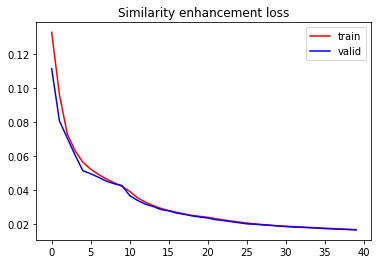

In [13]:
plt.plot(sim_loss_train, label="train", color="red")
plt.plot(sim_loss_valid, label="valid", color="blue")
plt.legend()
plt.title('Similarity enhancement loss')
plt.savefig('/Users/liyuanchao/Desktop/sim.png', dpi=400)
plt.show()

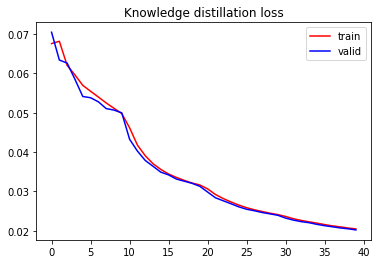

In [14]:
plt.plot(dis_loss_train, label="train", color="red")
plt.plot(dis_loss_valid, label="valid", color="blue")
plt.legend()
plt.title('Knowledge distillation loss')
plt.savefig('/Users/liyuanchao/Desktop/dis.png', dpi=400)
plt.show()